In [144]:
# Cell 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


Running on: cpu


In [145]:
# Cell 2: Load and prepare data
# Adjust this to wherever your training CSV lives
DATA_PATH = "data/Crop_recommendation.csv"  # Update this path as needed
df = pd.read_csv(DATA_PATH)

# These are exactly the columns your model expects:
feature_cols = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
assert all(c in df.columns for c in feature_cols), \
    f"Some expected features are missing: {set(feature_cols) - set(df.columns)}"

X = df[feature_cols].values
y = df["label"].values  # replace "label" if your column is named differently

print("Loaded data:", X.shape, "labels:", y.shape)
print("Unique crops:", np.unique(y))


Loaded data: (2200, 7) labels: (2200,)
Unique crops: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']


In [146]:
# Cell 3: Scale the data
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)


In [147]:
# Cell 4: Load the model
# Make sure the model module is in your path
import sys
sys.path.append(".")  # Add current directory to path if needed

# Define a simple model class if you don't have the original
class CropRecommendationNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CropRecommendationNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(64, 128)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(128, 64)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.fc4 = torch.nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

input_dim = X_scaled.shape[1]
output_dim = len(np.unique(y))

model = CropRecommendationNet(input_dim, output_dim).to(device)
# Comment out this line if you don't have a saved model yet
# model.load_state_dict(torch.load("model/baseline/baseline.hdf5", map_location=device))
model.eval()

print("Model ready:", model)
print("Number of features:", input_dim)
print("Number of crop classes:", output_dim)


Model ready: CropRecommendationNet(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=64, out_features=22, bias=True)
)
Number of features: 7
Number of crop classes: 22


In [148]:
# Cell 5: Prepare background data for SHAP
bg_size = min(100, X_scaled.shape[0])
X_bg = torch.from_numpy(X_scaled[:bg_size]).float().to(device)


In [149]:
# Cell 6: Calculate SHAP values
explainer = shap.DeepExplainer(model, X_bg)
shap_values = explainer.shap_values(
    torch.from_numpy(X_scaled).float().to(device),
    check_additivity=False
)


In [150]:
# Cell 7: Process SHAP values - FINAL FIX
# Convert SHAP values to numpy array
shap_values = np.array(shap_values)

# The shape should be (num_samples, num_features, num_classes)
print(f"SHAP values shape: {shap_values.shape}")
print(f"Number of samples: {shap_values.shape[0]}")
print(f"Number of features: {shap_values.shape[1]}")
print(f"Number of classes: {shap_values.shape[2]}")

# Calculate mean absolute SHAP values across all samples and classes
# Aggregate over samples (axis 0) and classes (axis 2)
mean_abs_shap = np.mean(np.abs(shap_values), axis=(0, 2))

# Verify matching feature dimensions
assert len(feature_cols) == len(mean_abs_shap), \
    f"Feature mismatch: {len(feature_cols)} vs {len(mean_abs_shap)}"

# Create importance DataFrame
df_imp = pd.DataFrame({
    "feature": feature_cols,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("\nFeature importance based on SHAP values:")
print(df_imp)

SHAP values shape: (2200, 7, 22)
Number of samples: 2200
Number of features: 7
Number of classes: 22

Feature importance based on SHAP values:
       feature  mean_abs_shap
6     rainfall       0.030717
0            N       0.011714
1            P       0.010558
5           ph       0.007314
2            K       0.005677
3  temperature       0.005630
4     humidity       0.005114


/var/folders/q0/_mhdcqr11t31xlbvft4rrt2c0000gn/T/ipykernel_6314/1706142863.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


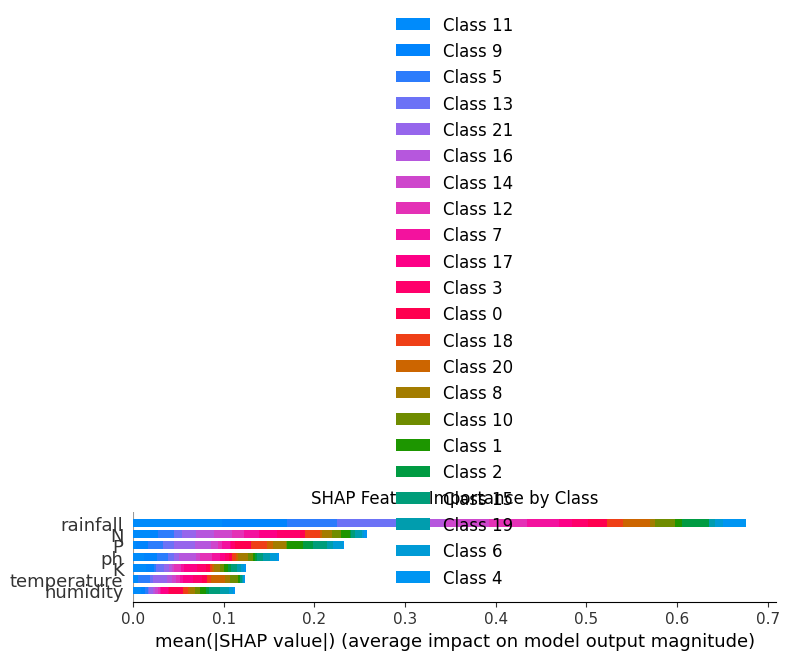

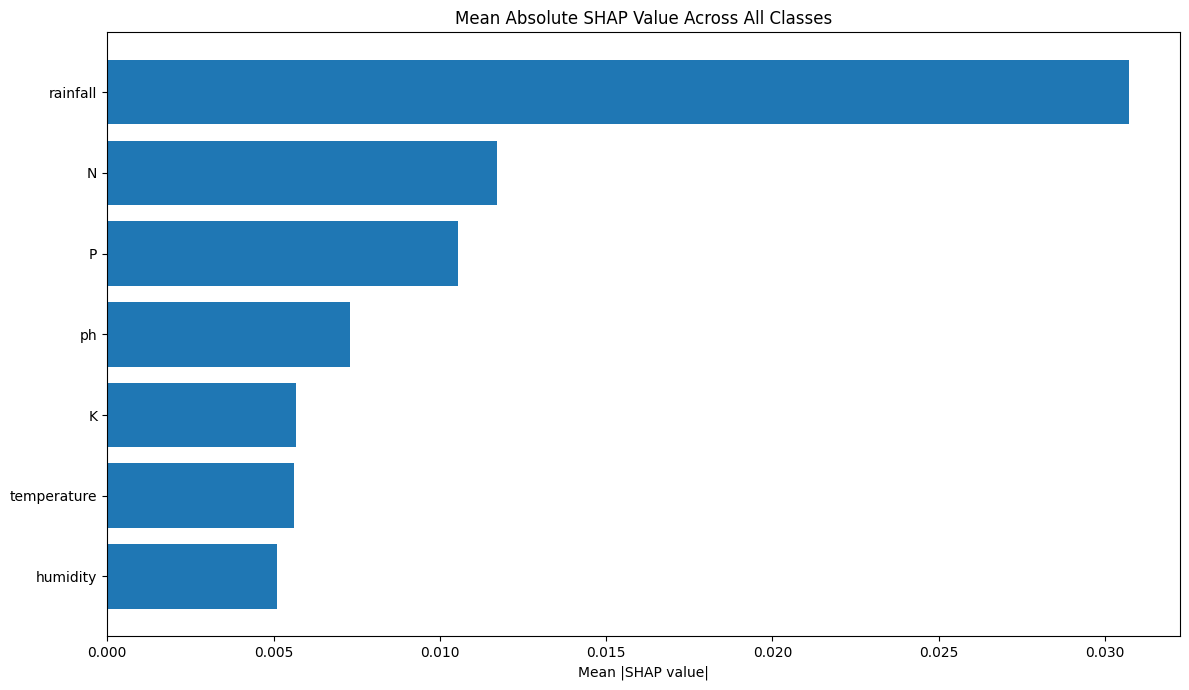

In [151]:
# Cell 8: Fixed SHAP Visualization for Multi-class Model
import shap
import matplotlib.pyplot as plt
import numpy as np

# For multi-class models, we need to reformat the SHAP values
# Convert from 3D array (samples, features, classes) to a list of 2D arrays (one array per class)
shap_values_list = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Use summary_plot with bar type instead of plots.bar
plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_values_list,
    X,
    feature_names=feature_cols,
    plot_type="bar",
    show=False
)

plt.title("SHAP Feature Importance by Class")
plt.tight_layout()
plt.show()

# If you want to see the overall importance across all classes in a simpler view
plt.figure(figsize=(12, 7))
# Calculate mean absolute SHAP values across all samples and classes
mean_abs_shap = np.mean(np.abs(shap_values), axis=(0, 2))

# Sort features by importance
indices = np.argsort(mean_abs_shap)
plt.barh(range(len(feature_cols)), mean_abs_shap[indices])
plt.yticks(range(len(feature_cols)), [feature_cols[i] for i in indices])
plt.xlabel("Mean |SHAP value|")
plt.title("Mean Absolute SHAP Value Across All Classes")
plt.tight_layout()
plt.show()
